In [247]:
import sys
# !{sys.executable} -m pip install gdown h5py
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
# url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
# output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)

In [248]:
path_to_data = '/Users/mverest/Documents/NX_414_Brain_Like_project/' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [249]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


In [250]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from tqdm import tqdm
from tqdm.auto import tqdm

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.model_selection import StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd



# The images are normalised to be compatible with ImageNet dataset --> standarization invere for from scratch mdodels
def inverse_normalisation(images):
    normalize_mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    normalize_std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    inv_images = (images * normalize_std + normalize_mean)
    return inv_images.astype(np.float32)

In [251]:
inv_stimulus_train = inverse_normalisation(stimulus_train)
inv_stimulus_val = inverse_normalisation(stimulus_val)

# check RGB channles are the same
diff01 = np.max(np.abs(inv_stimulus_train[:,0,:,:] - inv_stimulus_train[:,1,:,:]))
diff02 = np.max(np.abs(inv_stimulus_train[:,0,:,:] - inv_stimulus_train[:,2,:,:]))
print("Max abs diff ch0–ch1:", diff01)
print("Max abs diff ch0–ch2:", diff02)
 

#only keep channel 0
single_train = inv_stimulus_train[:, 1, :, :]  # shape (N, H, W)
single_val   = inv_stimulus_val  [:, 1, :, :]  # shape (M, H, W)`
# single_train = inv_stimulus_train
# single_val   = inv_stimulus_val
# single_train = inv_stimulus_train.mean(axis=1)
# single_val   = inv_stimulus_val.mean(axis=1)

# Flatten images for regression
X_flat_train = single_train.reshape(inv_stimulus_train.shape[0], -1)  
X_flat_val = single_val.reshape(inv_stimulus_val.shape[0], -1)  
Y_train = spikes_train  
Y_val = spikes_val  

X_flat_train.shape #should be (N, 224x224) --> ok !


Max abs diff ch0–ch1: 1.1920929e-07
Max abs diff ch0–ch2: 1.1920929e-07


(2592, 50176)

In [252]:
def compute_pearson_per_neuron(Y_val, Y_pred = Y_val):
    return np.array([
        pearsonr(Y_val[:, i], Y_pred[:, i])[0] for i in range(Y_val.shape[1])
    ])

def summarize(arr):
    p25 = np.percentile(arr, 25)
    med = np.median(arr)
    p75 = np.percentile(arr, 75)
    return {"P25": p25, "median": med, "P75": p75}

def eval_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    ev = explained_variance_score(y_val, y_pred, multioutput="raw_values")
    r  = compute_pearson_per_neuron(y_val, y_pred)

    return y_pred, summarize(ev), summarize(r)



def plot_performance_metrics(Y_pred, model_name, Y_val=Y_val, verbose = True):
    explained_var = explained_variance_score(Y_val, Y_pred, multioutput='raw_values')
    corr_per_neuron = compute_pearson_per_neuron(Y_val, Y_pred)

    if verbose:
        print(f"Explained Variance ({model_name}): {explained_var.median():.4f}")
        print(f"Mean Pearson Correlation ({model_name}): {corr_per_neuron.median():.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Explained variance 
    sns.histplot(explained_var, bins=30, kde=True, color="skyblue", ax=axes[0])
    axes[0].set_title(f"Explained Variance ({model_name})")
    axes[0].set_xlabel("Explained Variance")
    axes[0].set_ylabel("Number of Neurons")

    # Pearson correlation
    sns.histplot(corr_per_neuron, bins=30, kde=True, color="salmon", ax=axes[1])
    axes[1].set_title(f"Pearson Correlation ({model_name})")
    axes[1].set_xlabel("Pearson Correlation")
    axes[1].set_ylabel("Number of Neurons")

    plt.tight_layout()
    plt.show()
    
    
def boxplot_performance_metrics(list_pred, list_model_name, Y_val):
    ev = {}
    r = {}
    for i, Y_pred in enumerate(list_pred):
        model_name = list_model_name[i]
        explained_var = explained_variance_score(Y_val, Y_pred, multioutput='raw_values')
        corr_per_neuron = compute_pearson_per_neuron(Y_val, Y_pred)
        ev[model_name] = explained_var
        r[model_name] = corr_per_neuron

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Explained variance 
    axes[0].boxplot(list(ev.values()),  tick_labels=list(r.keys()))
    axes[0].set_ylabel("Explained Variance")
    # axes[0].set_ylim(-1, 1)

    # Pearson correlation
    axes[1].boxplot(list(r.values()), tick_labels=list(r.keys()))
    axes[1].set_ylabel("Pearson Correlation")
    # axes[1].set_ylim(-1, 1)

    plt.tight_layout()
    plt.show()

# Linear Baseline

EV :  {'P25': -0.5485553741455078, 'median': -0.43694776, 'P75': -0.3012164831161499} {'P25': -0.3199612498283386, 'median': -0.21061301, 'P75': -0.09382021427154541}
r  :  {'P25': 0.12033968046307564, 'median': 0.17770536, 'P75': 0.2572225108742714} {'P25': 0.12652516551315784, 'median': 0.20730019, 'P75': 0.28355757147073746}


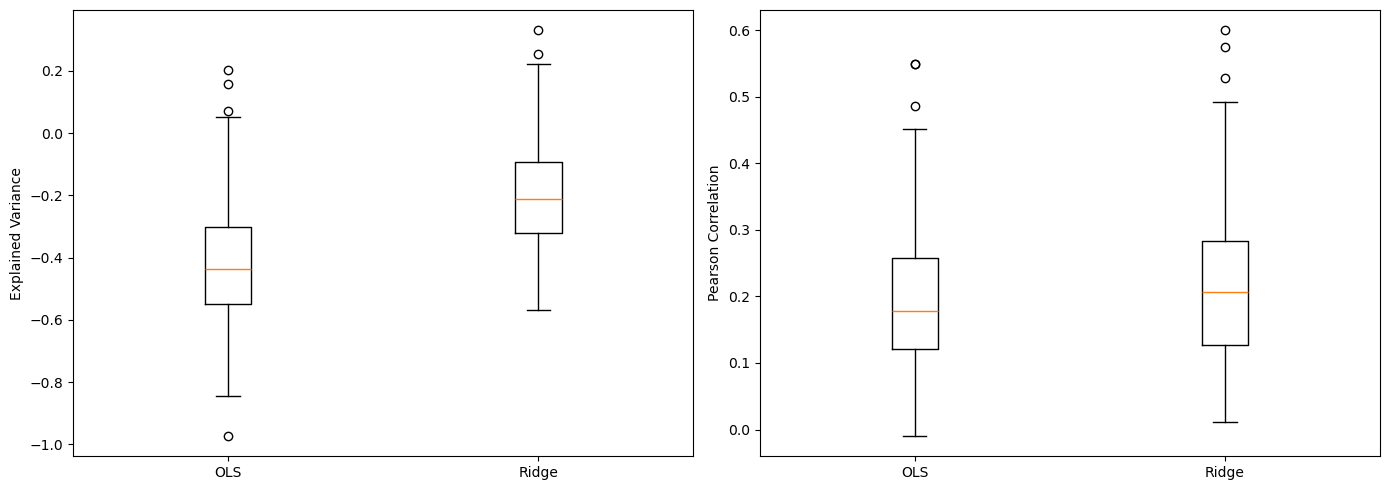

OLS: train EV=0.860, val EV=-0.427
Ridge: train EV=0.878, val EV=-0.200


In [253]:
baselines = {
    "OLS":   make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1000))
}


results, predictions = {}, {}

for name, pipe in baselines.items():
    y_hat, ev_str, r_str = eval_model(pipe, X_flat_train, Y_train, X_flat_val, Y_val)
    predictions[name]   = y_hat
    results[name]       = {"EV": ev_str, "r": r_str}
    # print(f"{name:<4} | EV {ev_str} | r {r_str}")


          # dict with formatted summaries
y_pred_OLS  = predictions["OLS"]
y_pred_Ridge = predictions["Ridge"]
print("EV : ",results["OLS"]["EV"], results["Ridge"]["EV"])
print("r  : ",results["OLS"]["r"], results["Ridge"]["r"])

boxplot_performance_metrics([y_pred_OLS, y_pred_Ridge], ["OLS", "Ridge"], Y_val)


def train_val_ev(pipe, X_tr, Y_tr, X_va, Y_va):
    pipe.fit(X_tr, Y_tr)
    y_tr_hat = pipe.predict(X_tr)
    y_va_hat = pipe.predict(X_va)
    ev_tr = explained_variance_score(Y_tr, y_tr_hat, multioutput="raw_values")
    ev_va = explained_variance_score(Y_va, y_va_hat, multioutput="raw_values")
    return ev_tr.mean(), ev_va.mean()

for name, pipe in baselines.items():
    ev_tr, ev_va = train_val_ev(pipe, X_flat_train, Y_train, X_flat_val, Y_val)
    print(f"{name}: train EV={ev_tr:.3f}, val EV={ev_va:.3f}")


# CV alpha and K

In [254]:
X = X_flat_train
Y= Y_train
X_val = X_flat_val
Y_val = Y_val
pca_dims = [400, 600, 800, 1000, 1200, 1400,1800]
alphas = np.logspace(0, 5, 6)
display(alphas, pca_dims)


cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
best_evs   = -np.inf
best_params = {}
results = []
print("Starting CV")

ev_scores = []
for n_comp in tqdm(pca_dims, desc="n_components"):
    for alpha in tqdm(alphas, desc=f"α @ n={n_comp}", leave=False):
        ev_folds = []
        r_folds  = []

        for train_idx, val_idx in cv.split(X, objects_train):
            X_tr, X_cv = X[train_idx], X[val_idx]
            y_tr, y_cv = Y[train_idx], Y[val_idx]

            # fresh pipeline each fold
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_cv = scaler.transform(X_cv)

            pca = PCA(n_components=n_comp, random_state=42)
            X_tr = pca.fit_transform(X_tr)
            X_cv = pca.transform(X_cv)

            model = Ridge(alpha=alpha)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_cv)

            ev  = explained_variance_score(y_cv, y_pred,
                                           multioutput='raw_values')
            r   = compute_pearson_per_neuron(y_cv, y_pred)

            ev_folds.append(np.median(ev))
            r_folds.append(np.median(r))

        mean_evs = np.mean(ev_folds)
        mean_r  = np.mean(r_folds)
        # … store results …
        
        results.append({
            'n_components':     n_comp,
            'alpha':            alpha,
            'cv_mean_evs':      mean_evs,
            'cv_mean_corr':     mean_r,
        })

        if mean_evs > best_evs:
            best_evs    = mean_evs
            best_params = {'n_components': n_comp, 'alpha': alpha}

print("\nBest CV params (by EVS):")
print(f"  n_components = {best_params['n_components']}")
print(f"  alpha        = {best_params['alpha']:.3f}")
print(f"  CV EVS       = {best_evs:.4f}")




array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])

[400, 600, 800, 1000, 1200, 1400, 1800]

Starting CV


n_components:   0%|          | 0/7 [01:09<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame(results)
results = results.sort_values(by='cv_mean_evs', ascending=False)
results 

,n_components,alpha,cv_mean_evs,cv_mean_corr
35,1400,100000.0,0.057916,0.245936
29,1200,100000.0,0.057437,0.245826
23,1000,100000.0,0.056973,0.244302
17,800,100000.0,0.056782,0.243597
11,600,100000.0,0.056020,0.242117
5,400,100000.0,0.054397,0.239542
4,400,10000.0,0.016301,0.219064
10,600,10000.0,0.011171,0.224059
16,800,10000.0,0.004993,0.223109
22,1000,10000.0,0.003314,0.222775


Test optimal model using : Best alpha: 100000.0, n_components: 1200
----------------------------------------------------------------




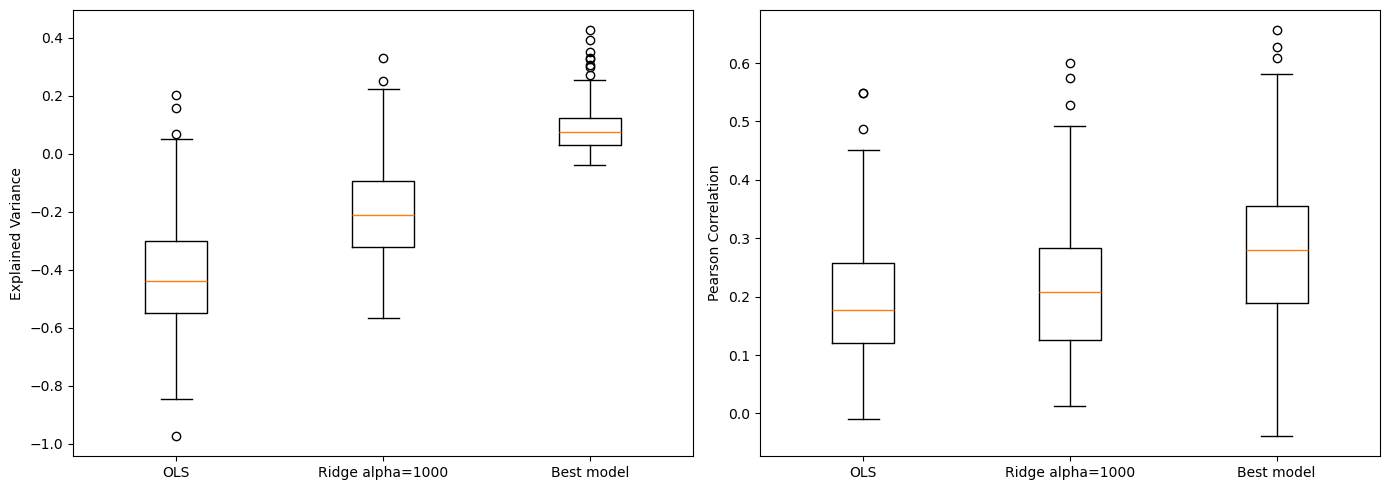

,P25,median,P75
0,0.032262,0.075804,0.124513


,P25,median,P75
0,0.189376,0.27914,0.355308


In [255]:
# best_alpha = best_params['alpha']
# best_n_comp = best_params['n_components']
best_alpha = 100000.0
best_n_comp = 1200
print(f"Test optimal model using : Best alpha: {best_alpha}, n_components: {best_n_comp}\n----------------------------------------------------------------\n\n")
best_model = make_pipeline(StandardScaler(), PCA(n_components=best_n_comp), Ridge(alpha=best_alpha))
best_model.fit(X_flat_train, Y_train)
y_pred_best = best_model.predict(X_flat_val)
boxplot_performance_metrics([y_pred_OLS, y_pred_Ridge, y_pred_best], ["OLS", "Ridge alpha=1000", "Best model"], Y_val)

ev = explained_variance_score(Y_val, y_pred_best, multioutput="raw_values")
r  = compute_pearson_per_neuron(Y_val, y_pred_best)

display(pd.DataFrame([summarize(ev)]), pd.DataFrame([summarize(r)]))



# Data Driven (CNN) 

In [268]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
import seaborn as sns

def inverse_normalisation(images):
    normalize_mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    normalize_std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    inv_images = (images * normalize_std + normalize_mean)
    return inv_images.astype(np.float32)

In [312]:
class NA_Dataset(Dataset):
    def __init__(self, images_array, spikes_array, transform = None):
        self.images = images_array
        self.target = spikes_array
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.target[idx]
        if self.transform:
            image = self.transform(image)
        else : 
            image = torch.tensor(image, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)        
        return image, target
    
class VanillaCNN(nn.Module):
    def __init__(self, num_channels, num_outputs, image_size=224):
        super(VanillaCNN, self).__init__()
        # First convolution block
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        
        # Second convolution block
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16 , kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        
        # Third convolution block
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
                
        self.pool = nn.MaxPool2d(2, 2)
        reduced_size = image_size // 8 
        self.fc1 = nn.Linear(32 * reduced_size * reduced_size, 512)
        self.fc2 = nn.Linear(512, num_outputs)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    


In [307]:
path_to_data = '/Users/mverest/Documents/NX_414_Brain_Like_project/'
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

Epoch 1/50 — Train Loss: 0.1351, Val Loss: 0.1391
Epoch 2/50 — Train Loss: 0.1332, Val Loss: 0.1387
Epoch 3/50 — Train Loss: 0.1353, Val Loss: 0.1402
Epoch 4/50 — Train Loss: 0.1357, Val Loss: 0.1406
Epoch 5/50 — Train Loss: 0.1362, Val Loss: 0.1415
Epoch 6/50 — Train Loss: 0.1358, Val Loss: 0.1409
Epoch 7/50 — Train Loss: 0.1358, Val Loss: 0.1410
Epoch 8/50 — Train Loss: 0.1358, Val Loss: 0.1410
Epoch 9/50 — Train Loss: 0.1384, Val Loss: 0.1433
Epoch 10/50 — Train Loss: 0.1358, Val Loss: 0.1412
Epoch 11/50 — Train Loss: 0.1375, Val Loss: 0.1427
Epoch 12/50 — Train Loss: 0.1354, Val Loss: 0.1407
Epoch 13/50 — Train Loss: 0.1358, Val Loss: 0.1409
Epoch 14/50 — Train Loss: 0.1379, Val Loss: 0.1434
Epoch 15/50 — Train Loss: 0.1457, Val Loss: 0.1491
Epoch 16/50 — Train Loss: 0.1355, Val Loss: 0.1406
Epoch 17/50 — Train Loss: 0.1357, Val Loss: 0.1409
Epoch 18/50 — Train Loss: 0.1350, Val Loss: 0.1402
Epoch 19/50 — Train Loss: 0.1367, Val Loss: 0.1410
Epoch 20/50 — Train Loss: 0.1353, Val Lo

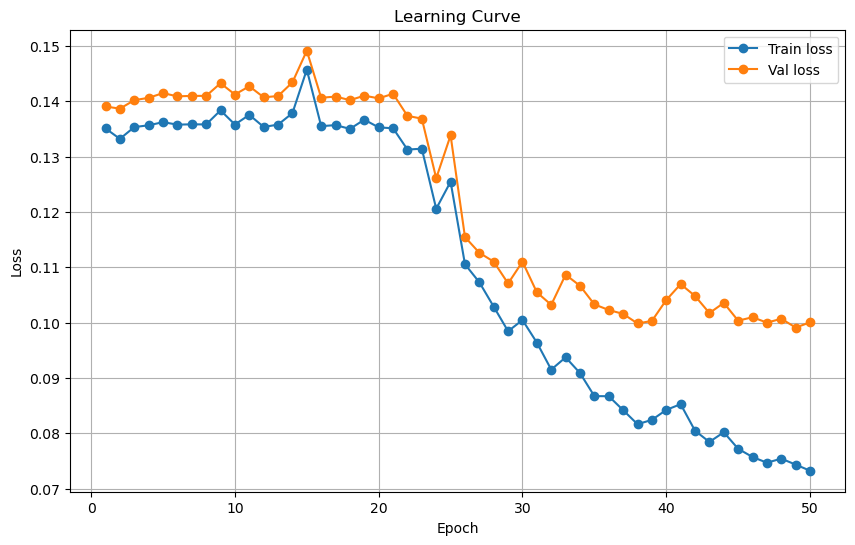

Median Explained Variance: 0.2634
Median Pearson Correlation: 0.5148


In [313]:

inv_stimulus_train = inverse_normalisation(stimulus_train)
inv_stimulus_val = inverse_normalisation(stimulus_val)
single_train = inv_stimulus_train[:, 1, :, :] 
single_val   = inv_stimulus_val  [:, 1, :, :]
channel_mean, channel_std = single_train.mean(), single_train.std()


trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean= [channel_mean], std= [channel_std])
]) 

df_train = NA_Dataset(single_train, spikes_train, trans)
df_val = NA_Dataset(single_val, spikes_val, trans)
train_loader = DataLoader(df_train, batch_size=16, shuffle=True)
val_loader = DataLoader(df_val, batch_size=16, shuffle=False)

device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"
num_channels = 1
image_size = stimulus_train.shape[2]
num_outputs = spikes_train.shape[1]


model = VanillaCNN(num_channels, num_outputs, image_size=image_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
num_epochs = 50

train_loss, val_loss = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    model.eval()
    running_train, total_train = 0.0, 0
    running_val,   total_val   = 0.0, 0
    predictions,   true_values = [], []

    with torch.no_grad():
        for images, targets in train_loader:
            bs = images.size(0)
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            l = criterion(outputs, targets)
            running_train += l.item() * bs
            total_train   += bs
        for images, targets in val_loader:
            bs = images.size(0)
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            l = criterion(outputs, targets)
            running_val   += l.item() * bs
            total_val     += bs
            predictions.append(outputs.cpu())
            true_values.append(targets.cpu())

    train_epoch_loss = running_train / total_train
    val_epoch_loss   = running_val   / total_val

    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {train_epoch_loss:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}")


plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), train_loss, marker='o', label='Train loss')
plt.plot(range(1, num_epochs+1), val_loss,   marker='o', label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


Y_pred = torch.cat(predictions, dim=0).numpy()
Y_val  = torch.cat(true_values, dim=0).numpy()

med_ev = np.median(explained_variance_score(Y_val, Y_pred, multioutput='raw_values'))
med_r  = np.median(compute_pearson_per_neuron(Y_val, Y_pred))

print(f"Median Explained Variance: {med_ev:.4f}")
print(f"Median Pearson Correlation: {med_r:.4f}")



# Freezed Weight of ResNet50

In [235]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

In [ ]:
path_to_data = '/Users/mverest/Documents/NX_414_Brain_Like_project/' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# set up your feature-extractor as before
resnet = resnet50(pretrained=True)
resnet.eval()
return_nodes = {
    'conv1': 'conv1',
    'layer1': 'layer1',
    'layer2': 'layer2',
    'layer3': 'layer3',
    'layer4': 'layer4',
    'avgpool': 'avgpool'
}
feature_extractor = create_feature_extractor(resnet, return_nodes=return_nodes).to(device)

# DATA ARE ALREADY GIVEN NORMALIZED FOR RESNET (BASED ON IMAGENET METRICS mean/std RGB channels)
imgs_tensor = torch.tensor(stimulus_train, dtype=torch.float32)
dataset     = TensorDataset(imgs_tensor)
loader      = DataLoader(dataset, batch_size=8, shuffle=False)

imgs_val_tensor = torch.tensor(stimulus_val, dtype=torch.float32)
val_dataset     = TensorDataset(imgs_val_tensor)
val_loader      = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [ ]:

explained_variances = {}
pearson_scores = {}
predictions = {}

for layer_name in return_nodes.values():
    print(f"\nProcessing layer: {layer_name}")
    activations_train = []
    with torch.no_grad():
        for batch in loader:
            imgs = batch[0].to(device)
            feats = feature_extractor(imgs)
            act = feats[layer_name].view(imgs.size(0), -1)
            activations_train.append(act.cpu().numpy())
    X_train = np.vstack(activations_train)

    activations_val = []
    
    with torch.no_grad():
        for batch in val_loader:
            imgs = batch[0].to(device)
            feats = feature_extractor(imgs)
            act = feats[layer_name].view(imgs.size(0), -1)
            activations_val.append(act.cpu().numpy())
    X_val = np.vstack(activations_val)

    if X_train.shape[1] < 1000:
        print(f"Not enough components for PCA, using original activations")
        X_pca_train = X_train
        X_pca_val = X_val
    else:
        pca = PCA(n_components=1000)
        X_pca_train = pca.fit_transform(X_train)
        X_pca_val = pca.transform(X_val) 

    # alpha = 100
    alpha = best_params['alpha']
    model = Ridge(alpha=alpha)
    model.fit(X_pca_train, spikes_train)

    Y_pred_val = model.predict(X_pca_val)
    predictions[layer_name] = Y_pred_val  

    ev = explained_variance_score(spikes_val, Y_pred_val, multioutput='uniform_average')
    pearson_corrs = compute_pearson_per_neuron(spikes_val, Y_pred_val)
    mean_pearson = np.mean(pearson_corrs)

    explained_variances[layer_name] = ev
    pearson_scores[layer_name] = mean_pearson

    print(f"Layer {layer_name} | VAL EV: {ev:.4f} | mean Pearson: {mean_pearson:.4f}, ridge alpha: {alpha}")
    
    plot_performance_metrics(Y_pred_val, layer_name + f" Ridge-L2={alpha}", verbose=False)

    
